# Exploratory Data Analysis

### Basic Setting

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans


warnings.filterwarnings("ignore")
sns.set_theme()
# please check if the font exists in your system
plt.rcParams["font.family"] = "Hiragino Maru Gothic Pro"

# Outline
1. Raw Data Preparation
2. Data Aggregation
3. Individal Feature Visualization
4. Temperoal Effects
5. Spatial Effects
6. GMV - User vs. Store
7. Recency


## Raw Data Preparation

### Data loading

In [2]:
users_pdf = pd.read_csv("../data/users.csv").rename({"id": "user_id"}, axis=1)
transaction_pdf = pd.read_csv("../data/transactions.csv", parse_dates=["event_occurrence"])
stores_pdf = pd.read_csv("../data/stores.csv").rename({"id": "store_id"}, axis=1)

print(f"Users -\n columns: {list(users_pdf.columns)};\n shape: {users_pdf.shape}")
print(
    f"Transactions -\n columns: {list(transaction_pdf.columns)};\n shape: {transaction_pdf.shape}"
)
print(f"Stores -\n columns: {list(stores_pdf.columns)};\n shape: {stores_pdf.shape}")


Users -
 columns: ['user_id', 'gender', 'age'];
 shape: (9961, 3)
Transactions -
 columns: ['id', 'user_id', 'store_id', 'event_occurrence', 'amount'];
 shape: (1582260, 5)
Stores -
 columns: ['store_id', 'nam', 'laa', 'category', 'lat', 'lon'];
 shape: (99991, 6)


In [3]:
users_pdf.head()

,user_id,gender,age
0,3cf2d95c-851a-3e66-bd62-36050c1aa8dd,M,30.0
1,a85536f3-1bf8-fbeb-d06e-62e6dc5a2a83,M,55.0
2,355a293c-2c15-d6bd-45ce-cd3c275ee5a9,M,40.0
3,61fb5b45-9bf8-1659-7a0c-b6f85a0f870b,NaN,NaN
4,ff9e16ef-3a0b-9373-567f-fb07cbc96874,M,90.0


### Missing Value Detection
- Conclusion: there are only few missing user records. Can be 996 records found below.
- Note: the missing pattern will be taken care afterwards. Can use imputation techniques or other insensive ML methods.

In [4]:
print(f"Overall User Size: {users_pdf.shape[0]} with {users_pdf.shape[0] - users_pdf.drop_duplicates("user_id").shape[0]} duplicate reords")
print("Missing rate")
display(users_pdf.isnull().sum() / users_pdf.shape[0])


Overall User Size: 9961 with 0 duplicate reords
Missing rate


user_id    0.000000
gender     0.099990
age        0.049995
dtype: float64

In [5]:
# Missing Record
users_pdf[users_pdf.isnull().any(axis=1)]

,user_id,gender,age
3,61fb5b45-9bf8-1659-7a0c-b6f85a0f870b,NaN,NaN
5,921cbaf8-ef1a-c751-17ea-2caaee0d4e92,NaN,49.0
11,4d7af432-1eb9-b387-d876-0cce8470f26d,NaN,NaN
16,9b83a437-28b7-405b-abc2-ded76bd8e65f,NaN,85.0
25,63d45aa3-de2b-5082-9342-365328beae8e,NaN,85.0
...,...,...,...
9910,c76f432c-dc5a-a6c9-d1ab-d865ee9d0e10,NaN,35.0
9921,bc315be3-3269-871d-b008-1c1840fc9f2d,NaN,43.0
9934,5b4720dc-90d3-37af-4365-dedb8522dd90,NaN,88.0
9944,b934718f-2d49-2ca2-41f4-317df5141524,NaN,62.0


In [6]:
print(f"Overall Store Size: {stores_pdf.shape[0]} with {stores_pdf.shape[0] - stores_pdf.drop_duplicates("store_id").shape[0]} duplicate reords")
print("Missing rate")
display(stores_pdf.isnull().sum() / stores_pdf.shape[0])

Overall Store Size: 99991 with 0 duplicate reords
Missing rate


store_id    0.0
nam         0.0
laa         0.0
category    0.0
lat         0.0
lon         0.0
dtype: float64

In [7]:
print(f"Overall Transaction Size: {transaction_pdf.shape[0]} with {transaction_pdf.shape[0] - transaction_pdf.drop_duplicates("id").shape[0]} duplicate reords")
print("Missing rate")
display(transaction_pdf.isnull().sum() / transaction_pdf.shape[0])

Overall Transaction Size: 1582260 with 0 duplicate reords
Missing rate


id                  0.0
user_id             0.0
store_id            0.0
event_occurrence    0.0
amount              0.0
dtype: float64

## Data Aggregation
- Summary: We integrate `user`, `store`, and `transactions` into one comprehensive table, excluding null values in the `user` data. Subsequent analyses will help identify any abnormal patterns.

In [8]:
# Remove users with missing data
clean_users_pdf = users_pdf.dropna()


added_user_to_transactions_pdf = pd.merge(transaction_pdf, clean_users_pdf, on=["user_id"], how="inner")
full_data_pdf = pd.merge(
    added_user_to_transactions_pdf, stores_pdf, on=["store_id"], how="left"
)

full_data_pdf.head(3)


,id,user_id,store_id,event_occurrence,amount,gender,age,nam,laa,category,lat,lon
0,a555eb55-1da4-6087-b5ab-06b35b608002,93098549-3ff0-e579-01c3-df9183278f64,a3c7874b-75df-9cf2-62ab-cf58be5d9e0e,2020-01-01 06:40:43.323987,315,M,88.0,Saitama Ken,Soka Shi,コンビニ,35.830649,139.809781
1,f699b867-e70c-5160-90c8-7dfa32dce0da,35ba9da1-98d0-cbb7-7844-e648601b7208,1d59adf3-94f2-f5f8-46c6-8558c544a3a9,2020-01-01 07:04:25.968615,1646,M,44.0,Gunma Ken,Meiwa Cho,ショッピング,36.216801,139.562541
2,5c3f8abc-f4e6-94fd-7b13-fe0efd4e4591,63cb5ee0-a457-9975-5455-4d76109bc754,c835f09d-ac5b-2005-1959-f452456a746a,2020-01-01 07:06:16.164563,385,M,16.0,Hiroshima Ken,Fukuyama Shi,コンビニ,34.642260,133.257595


In [9]:
print(f"Row size: {full_data_pdf.shape[0]}, Column size: {full_data_pdf.shape[1]}")
display(full_data_pdf.dtypes)


Row size: 1421978, Column size: 12


id                          object
user_id                     object
store_id                    object
event_occurrence    datetime64[ns]
amount                       int64
gender                      object
age                        float64
nam                         object
laa                         object
category                    object
lat                        float64
lon                        float64
dtype: object

### Individual Feature Distribution with Comparison
#### Summary:
- The aggregated data closely resembles the original features' characteristics. Further insights can be extracted from the following distributions or by analyzing the feature importance of the trained model. No anomalies are observed.

#### New Feature: Discretized Age
- We discretized the age feature into quantiles for better understanding and analysis. The distribution of discretized age across different datasets is visualized below.

Text(0.5, 1.0, 'Clean Users')

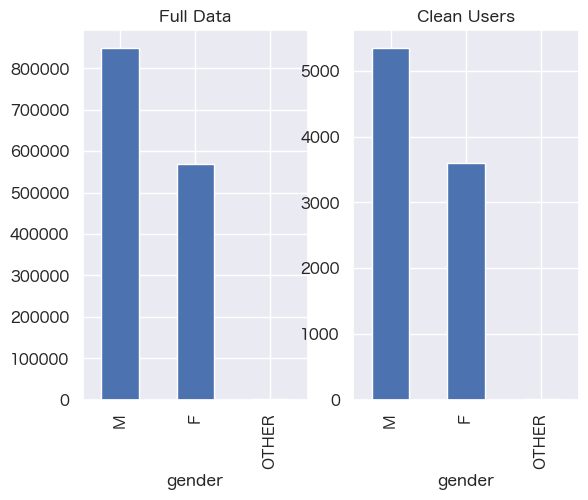

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2)

full_data_pdf.gender.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Full Data')

clean_users_pdf.gender.value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Clean Users')

Age Range: [15.0, 90.0]


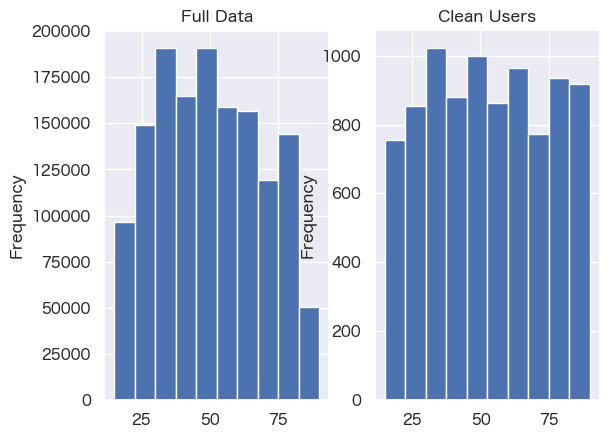

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2)

full_data_pdf.age.plot(kind='hist', ax=axes[0])
axes[0].set_title('Full Data')

clean_users_pdf.age.plot(kind='hist', ax=axes[1])
axes[1].set_title('Clean Users')

# The Age is in a reasonable range
print(f"Age Range: [{min(clean_users_pdf.age)}, {max(clean_users_pdf.age)}]")



Age Range: [15.0, 90.0]


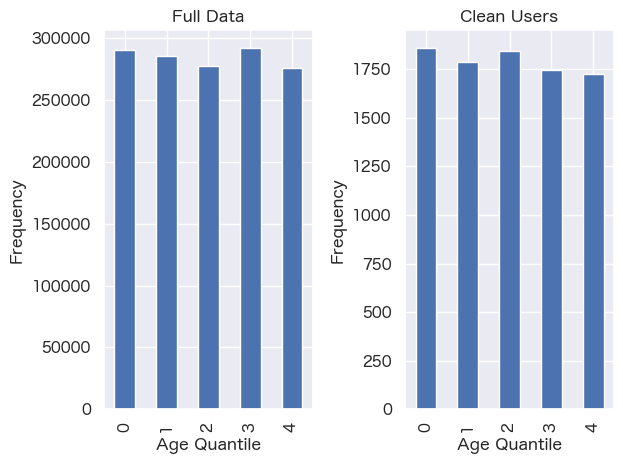

In [12]:
# Define the number of quantiles
num_quantiles = 5  # You can adjust this value as needed

# Split age into quantiles and create age labels
full_data_pdf['age_label'] = pd.qcut(full_data_pdf['age'], num_quantiles, labels=False)
clean_users_pdf['age_label'] = pd.qcut(clean_users_pdf['age'], num_quantiles, labels=False)

# Plot histograms with age labels
fig, axes = plt.subplots(nrows=1, ncols=2)

full_data_pdf['age_label'].value_counts().sort_index().plot(kind='bar', ax=axes[0])
axes[0].set_title('Full Data')
axes[0].set_xlabel('Age Quantile')
axes[0].set_ylabel('Frequency')

clean_users_pdf['age_label'].value_counts().sort_index().plot(kind='bar', ax=axes[1])
axes[1].set_title('Clean Users')
axes[1].set_xlabel('Age Quantile')
axes[1].set_ylabel('Frequency')

# Show the age range for clean users
print(f"Age Range: [{min(clean_users_pdf.age)}, {max(clean_users_pdf.age)}]")

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Stores')

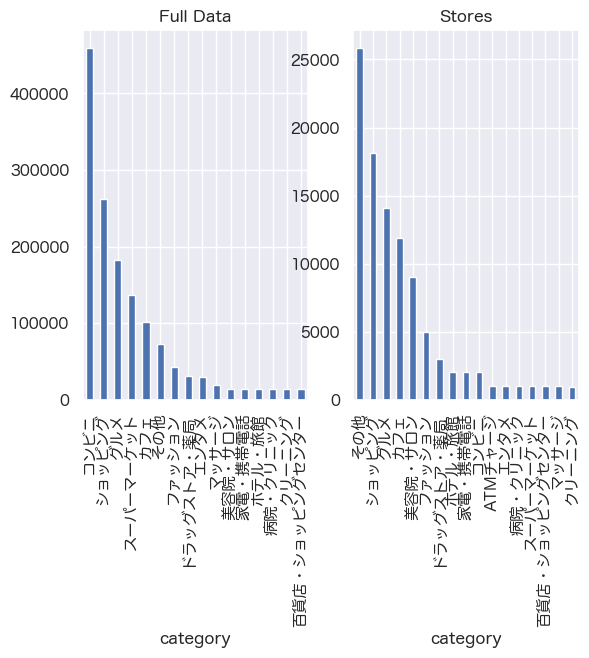

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2)

full_data_pdf.category.value_counts().plot(kind='bar', ax=axes[0])
axes[0].set_title('Full Data')

stores_pdf.category.value_counts().plot(kind='bar', ax=axes[1])
axes[1].set_title('Stores')


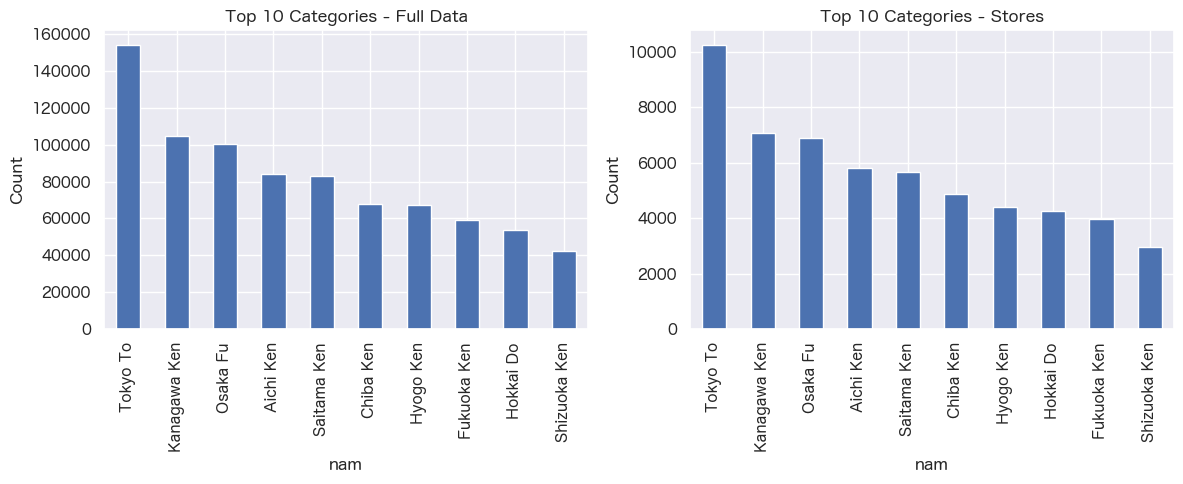

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot top 10 categories for 'nam' in the 'full_data_pdf'
full_data_pdf.nam.value_counts().head(10).plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 10 Categories - Full Data')
axes[0].set_ylabel('Count')

# Plot top 10 categories for 'nam' in the 'stores_pdf'
stores_pdf.nam.value_counts().head(10).plot(kind='bar', ax=axes[1])
axes[1].set_title('Top 10 Categories - Stores')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

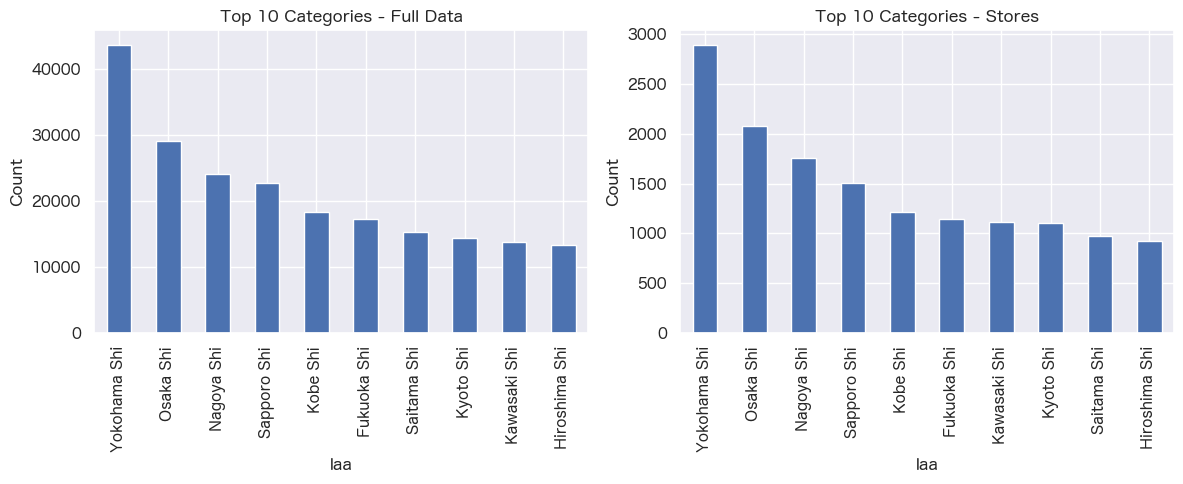

In [15]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot top 10 categories for 'laa' in the 'full_data_pdf'
full_data_pdf.laa.value_counts().head(10).plot(kind='bar', ax=axes[0])
axes[0].set_title('Top 10 Categories - Full Data')
axes[0].set_ylabel('Count')

# Plot top 10 categories for 'laa' in the 'stores_pdf'
stores_pdf.laa.value_counts().head(10).plot(kind='bar', ax=axes[1])
axes[1].set_title('Top 10 Categories - Stores')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

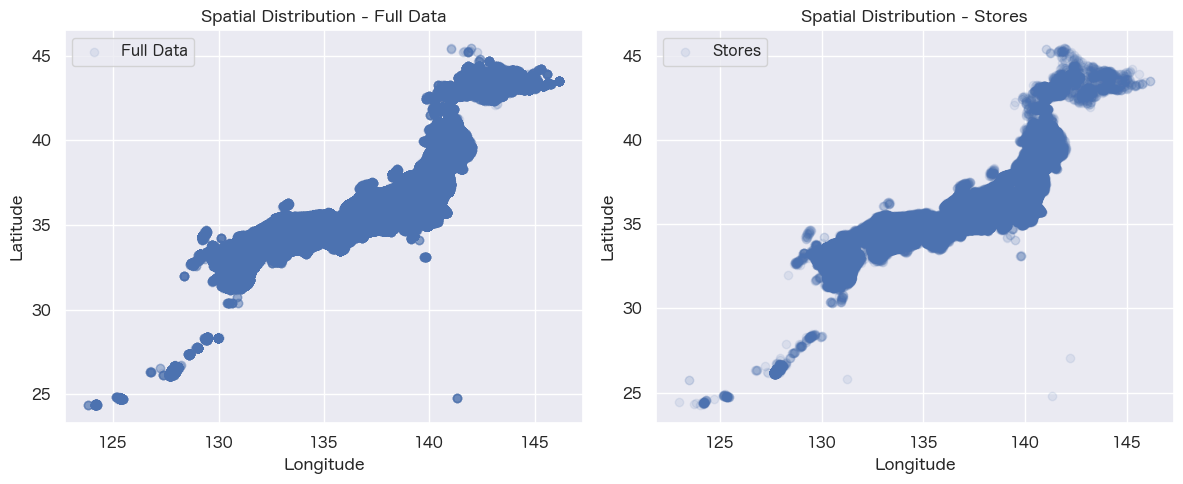

In [16]:
# Create scatter plot for 'full_data_pdf'
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(full_data_pdf['lon'], full_data_pdf['lat'], alpha=0.1, marker='o', label='Full Data')
plt.title('Spatial Distribution - Full Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Create scatter plot for 'stores_pdf'
plt.subplot(1, 2, 2)
plt.scatter(stores_pdf['lon'], stores_pdf['lat'], alpha=0.1, marker='o', label='Stores')
plt.title('Spatial Distribution - Stores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

plt.tight_layout()
plt.show()


### Temporal Effects
- Summary: To simplify, we analyze temporal effects by categorizing them into `is_weekend`, `month`, and `season`. The significance of each can be observed in the following panels.
- Note: While a time series-like (ARIMA or RNN/LSTM) model could address the problem more comprehensively, it might be computationally intensive for code challenges.

In [62]:
# Assuming 'event_occurrence' is the column representing the date in your dataframe
full_data_pdf['event_occurrence'] = pd.to_datetime(full_data_pdf['event_occurrence'])

# Extracting temporal features
full_data_pdf['hour'] = full_data_pdf['event_occurrence'].dt.hour
full_data_pdf['weekday'] = full_data_pdf['event_occurrence'].dt.weekday
# Bin the data into morning, afternoon, and evening
full_data_pdf['is_weekend'] = (full_data_pdf['event_occurrence'].dt.weekday >= 5) * 1  # True for weekdays, False for weekends
full_data_pdf['season'] = (full_data_pdf['event_occurrence'].dt.month % 12 + 3) // 3  # Calculating the season based on months
full_data_pdf['month'] = full_data_pdf['event_occurrence'].dt.month

# Displaying the modified dataframe
print(full_data_pdf[['event_occurrence', 'is_weekend', 'season', 'month']])

                  event_occurrence  is_weekend  season  month
0       2020-01-01 06:40:43.323987           0       1      1
1       2020-01-01 07:04:25.968615           0       1      1
2       2020-01-01 07:06:16.164563           0       1      1
3       2020-01-01 07:07:26.029685           0       1      1
4       2020-01-01 07:12:24.448015           0       1      1
...                            ...         ...     ...    ...
1421973 2021-12-31 16:42:04.018285           0       1     12
1421974 2021-12-31 16:48:25.112299           0       1     12
1421975 2021-12-31 16:54:20.392210           0       1     12
1421976 2021-12-31 17:04:31.609495           0       1     12
1421977 2021-12-31 17:09:49.237044           0       1     12

[1421978 rows x 4 columns]


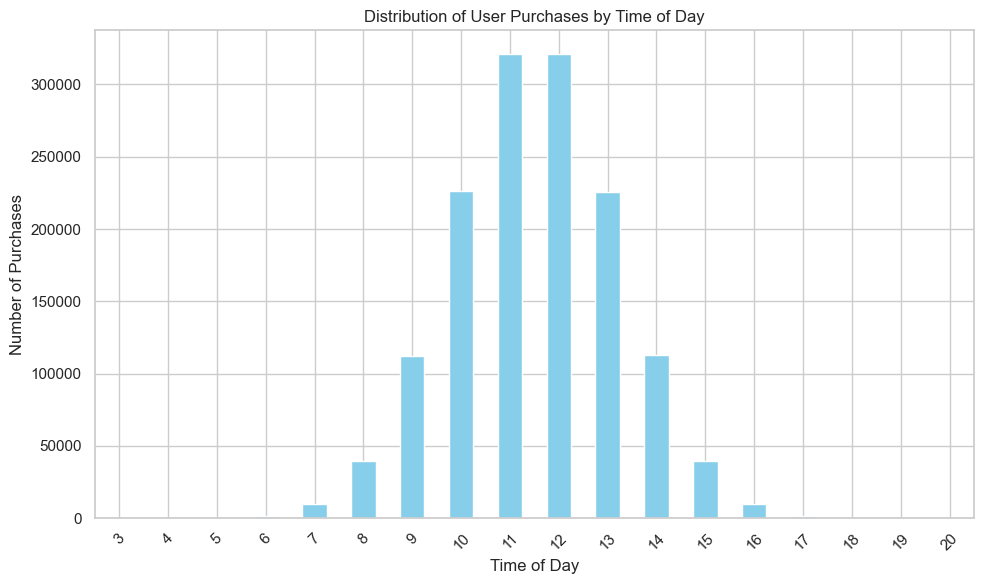

In [63]:
plt.figure(figsize=(10, 6))
full_data_pdf['hour'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of User Purchases by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Number of Purchases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

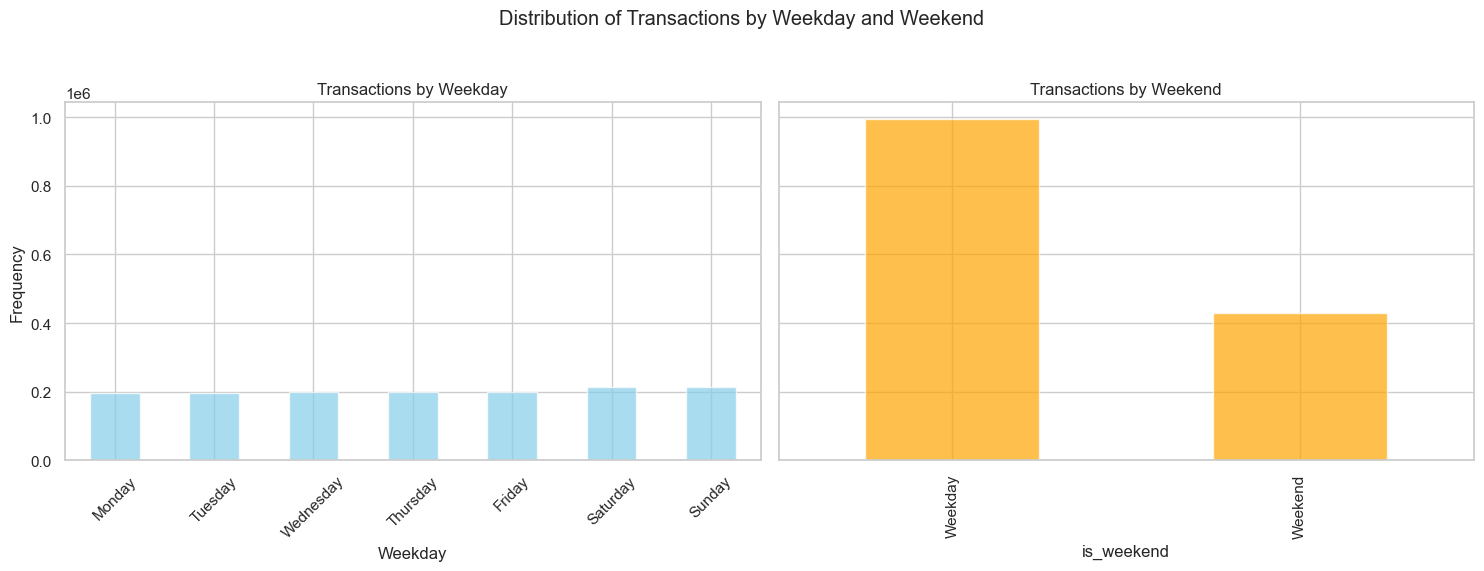

In [76]:
# Ensure is_weekend column contains binary values (0 or 1)
full_data_pdf['is_weekend'] = full_data_pdf['is_weekend'].astype(int)

# Create a figure with subplots for each weekend
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharey=True)

# Plot distribution of transactions on weekdays/weekends
weekday_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
full_data_pdf['weekday'].value_counts().sort_index().plot.bar(ax=axes[0], color='skyblue', alpha=0.7)
axes[0].set_title('Transactions by Weekday')
axes[0].set_xlabel('Weekday')
axes[0].set_ylabel('Frequency')
axes[0].set_xticklabels(weekday_labels, rotation=45)

axes[1].set_title('Transactions by Weekend')
axes[1].set_xlabel('Weekend')
axes[1].set_ylabel('Frequency')

# Plot distribution of transactions on weekdays/weekends
weekend_labels = ['Weekday', 'Weekend']
full_data_pdf['is_weekend'].value_counts().sort_index().plot.bar(ax=axes[1], color='orange', alpha=0.7)
axes[1].set_xticklabels(weekend_labels)

# Add a title and adjust layout
plt.suptitle('Distribution of Transactions by Weekday and Weekend')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


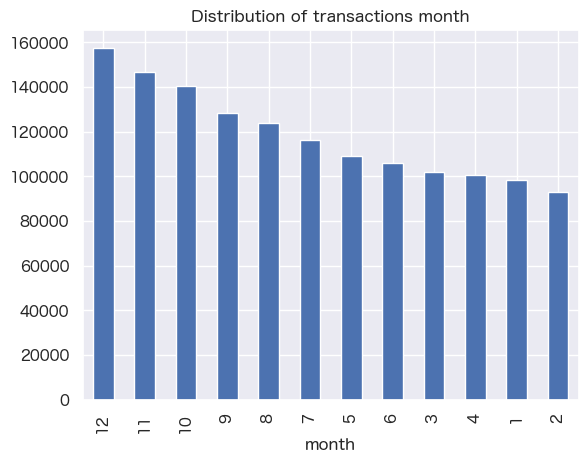

In [19]:
full_data_pdf.month.value_counts().plot(kind='bar')
plt.title('Distribution of transactions month')
plt.show()


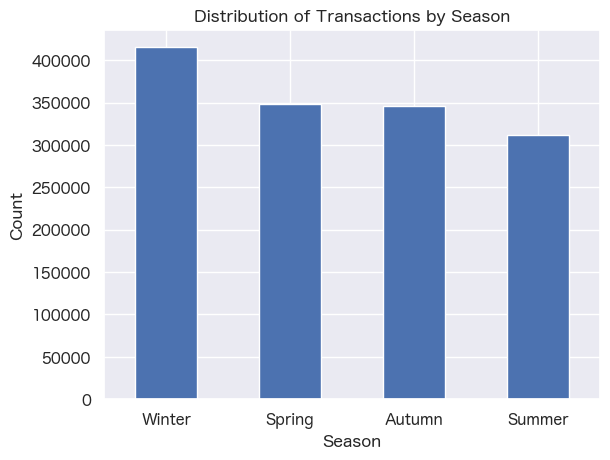

In [20]:
# Assuming full_data_pdf.season contains numeric values representing seasons
# Create a mapping from numeric values to custom labels
season_labels = {1: 'Spring', 2: 'Summer', 3: 'Autumn', 4: 'Winter'}

# Map the numeric values to custom labels
full_data_pdf['season_labels'] = full_data_pdf['season'].map(season_labels)

# Plotting the distribution with custom labels
full_data_pdf['season_labels'].value_counts().plot(kind='bar')
plt.title('Distribution of Transactions by Season')
plt.xlabel('Season')
plt.ylabel('Count')

# Display the custom labels on the x-axis
plt.xticks(rotation=0)  # Set rotation based on your preference
plt.show()


#### Analysis: Purchase Hours Across Different Period
- Objective: Examine purchase hour patterns across weekdays, months, and seasons.

- Findings: Purchase hours vary across different weekdays, months, showing seasonal trends.

- Implications: Understanding these patterns can inform marketing strategies and resource allocation to better meet customer demand and improve business performance. Further analysis can provide deeper insights into the underlying drivers of these patterns.


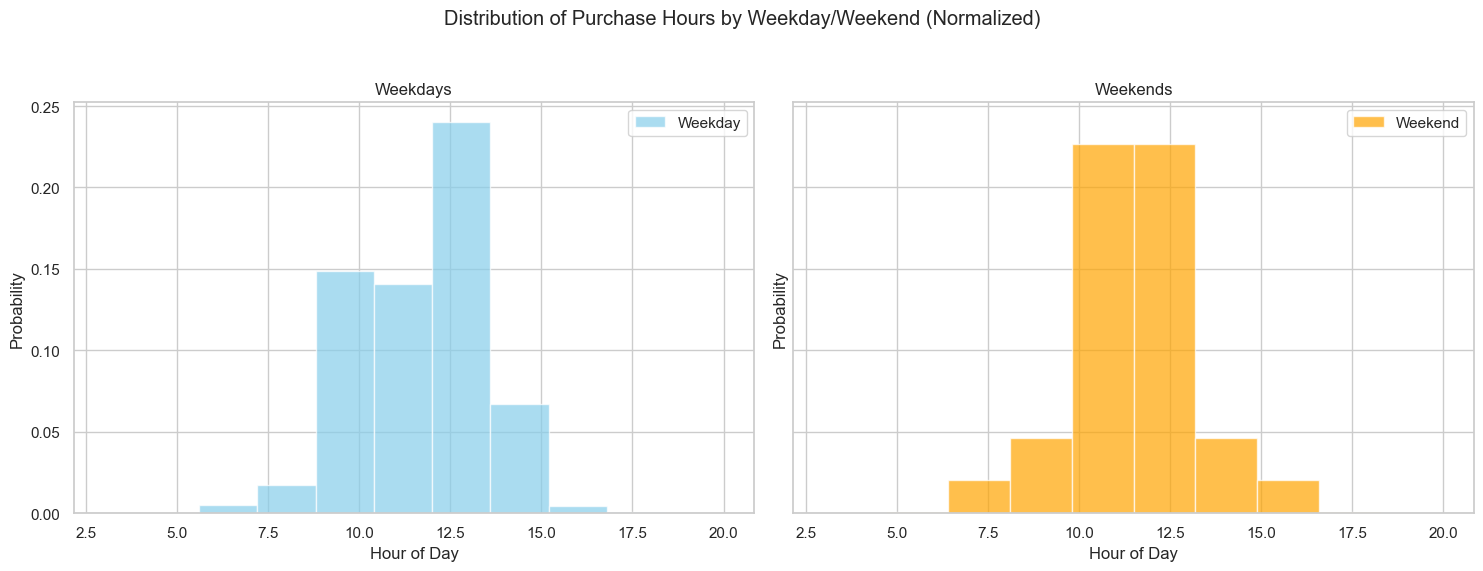

In [56]:
# Create a figure with subplots for each weekend
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6), sharex=True, sharey=True)

# Plot distribution of purchase hours on weekdays
axes[0].hist(full_data_pdf[full_data_pdf['is_weekend'] == 0]['hour'], color='skyblue', alpha=0.7, label='Weekday', density=True)
axes[0].set_title('Weekdays')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Probability')
axes[0].legend()

# Plot distribution of purchase hours on weekends
axes[1].hist(full_data_pdf[full_data_pdf['is_weekend'] == 1]['hour'], color='orange', alpha=0.7, label='Weekend', density=True)
axes[1].set_title('Weekends')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Probability')
axes[1].legend()

# Add a title and adjust layout
plt.suptitle('Distribution of Purchase Hours by Weekday/Weekend (Normalized)')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


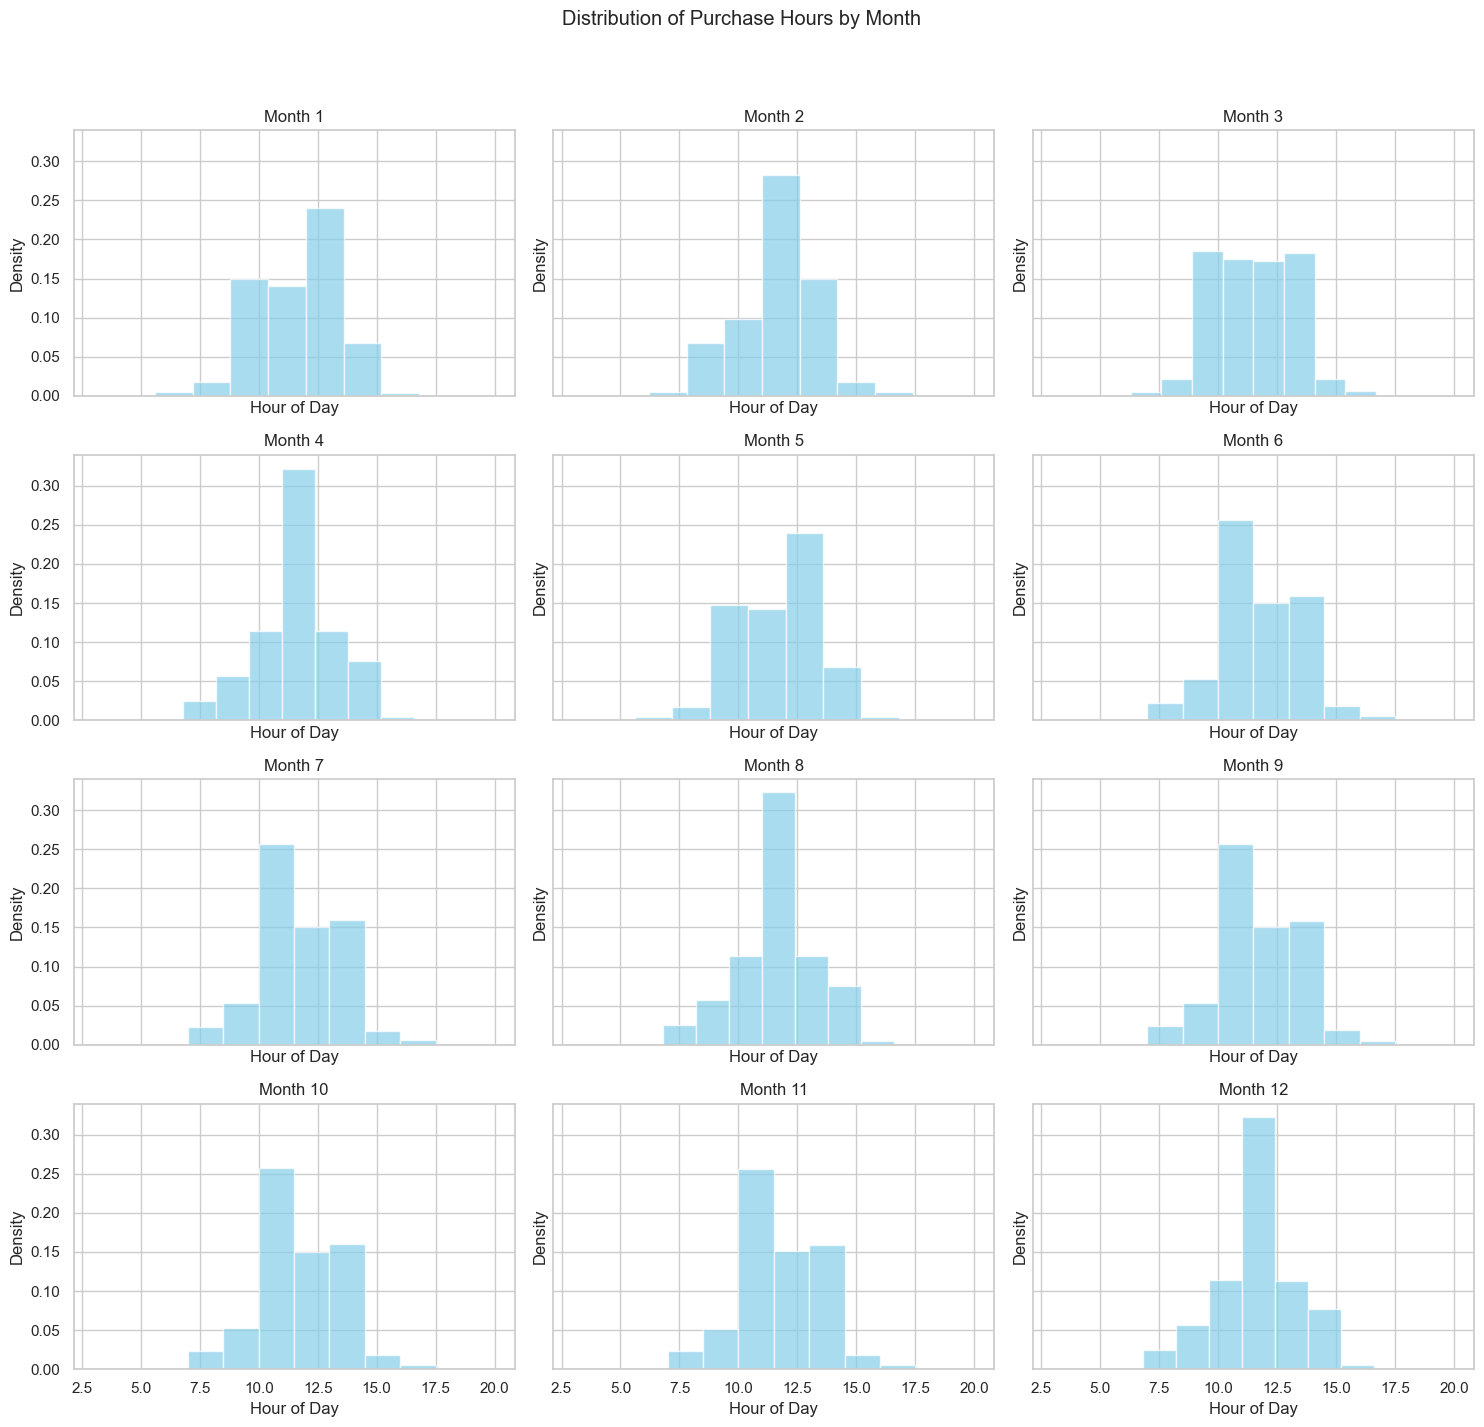

In [89]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15), sharex=True, sharey=True)

# Iterate over each month and plot the distribution of purchase hours
for month in range(1, 13):
    row = (month - 1) // 3
    col = (month - 1) % 3
    ax = axes[row, col]
    month_data = full_data_pdf[full_data_pdf['month'] == month]
    ax.hist(full_data_pdf[full_data_pdf['month'] == month]['hour'], color='skyblue', alpha=0.7, density=True)
    ax.set_title(f'Month {month}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Density')
# Add a title and adjust layout
plt.suptitle('Distribution of Purchase Hours by Month')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

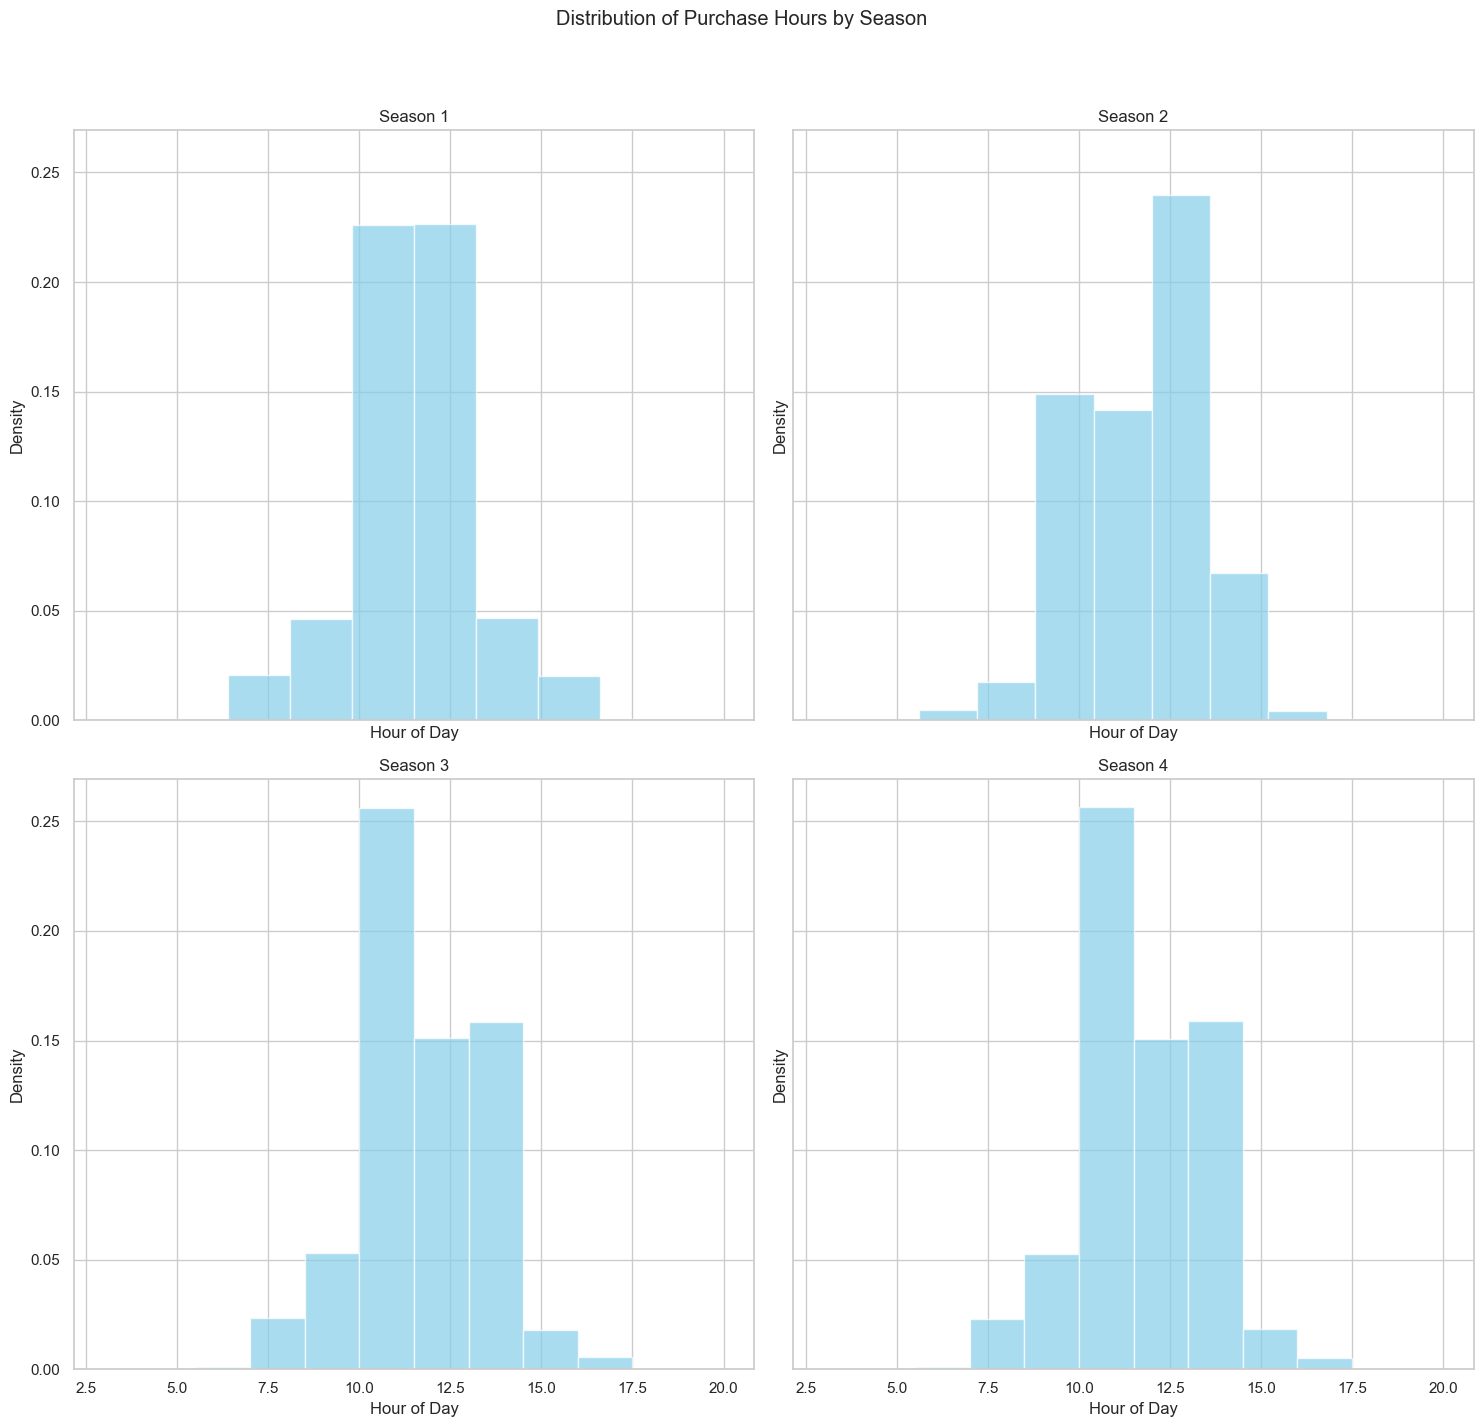

In [88]:
# Create a figure with subplots for each season
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 15), sharex=True, sharey=True)

# Iterate over each season and plot the distribution of purchase hours
for season in range(1, 5):
    row = (season - 1) // 2
    col = (season - 1) % 2
    ax = axes[row, col]
    season_data = full_data_pdf[full_data_pdf['season'] == season]
    ax.hist(season_data['hour'], color='skyblue', alpha=0.7, density=True)
    ax.set_title(f'Season {season}')
    ax.set_xlabel('Hour of Day')
    ax.set_ylabel('Density')

# Add a title and adjust layout
plt.suptitle('Distribution of Purchase Hours by Season')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Spatial Visualization
- Summary: Noteworthy regions with elevated GMV are highlighted, emphasizing the significance of specific locations.
- New feautures: we label the locations by KMeans

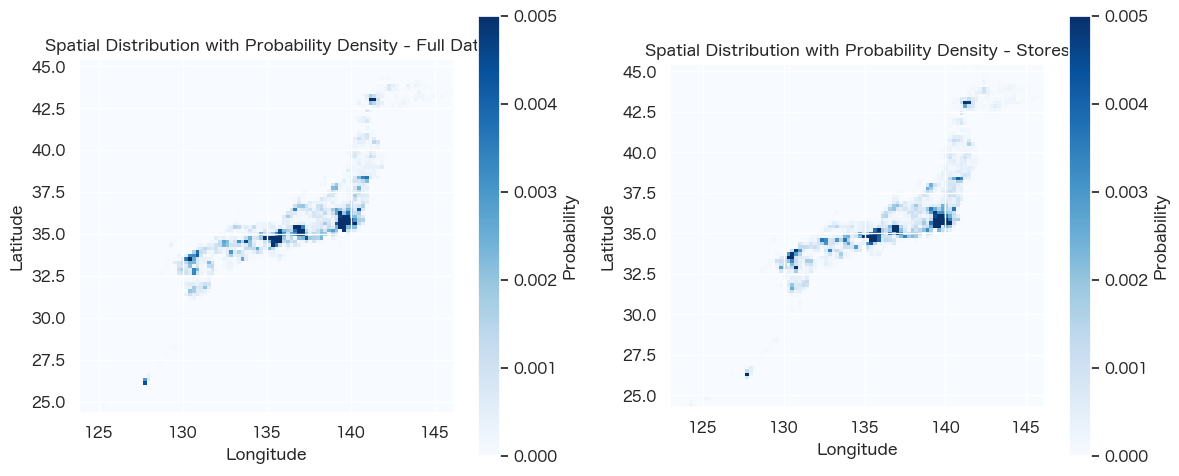

In [21]:
# Assuming 'density' is the column representing the density in your dataframes
counts_full, xedges_full, yedges_full = np.histogram2d(full_data_pdf['lon'], full_data_pdf['lat'], bins=100)
full_probability_density = counts_full / np.sum(counts_full)

counts_stores, xedges_stores, yedges_stores = np.histogram2d(stores_pdf['lon'], stores_pdf['lat'], bins=100)
stores_probability_density = counts_stores / np.sum(counts_stores)

plt.figure(figsize=(12, 5))

# Plot for full_data_pdf
plt.subplot(1, 2, 1)
plt.imshow(full_probability_density.T, extent=(xedges_full.min(), xedges_full.max(), yedges_full.min(), yedges_full.max()), vmax=0.005, cmap='Blues', origin='lower')
plt.colorbar(label='Probability')
plt.title('Spatial Distribution with Probability Density - Full Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Plot for stores_pdf
plt.subplot(1, 2, 2)
plt.imshow(stores_probability_density.T, extent=(xedges_stores.min(), xedges_stores.max(), yedges_stores.min(), yedges_stores.max()), vmax=0.005, cmap='Blues', origin='lower')
plt.colorbar(label='Probability')
plt.title('Spatial Distribution with Probability Density - Stores')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()
plt.show()

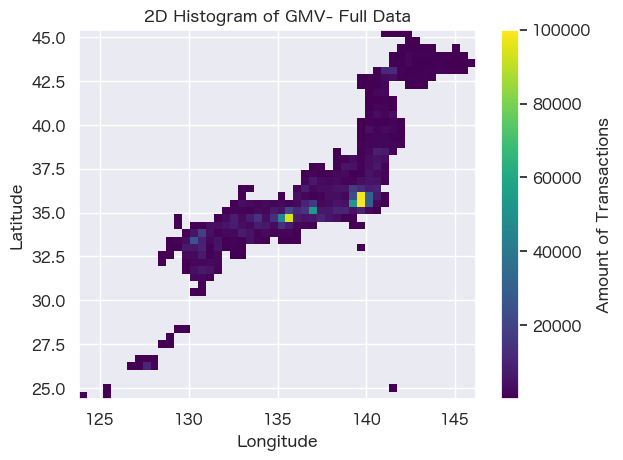

In [22]:
plt.hist2d(full_data_pdf['lon'], full_data_pdf['lat'], bins=(50, 50), cmap='viridis', cmin=1,vmax=100000)
plt.colorbar(label='Amount of Transactions')
plt.title('2D Histogram of GMV- Full Data')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.show()

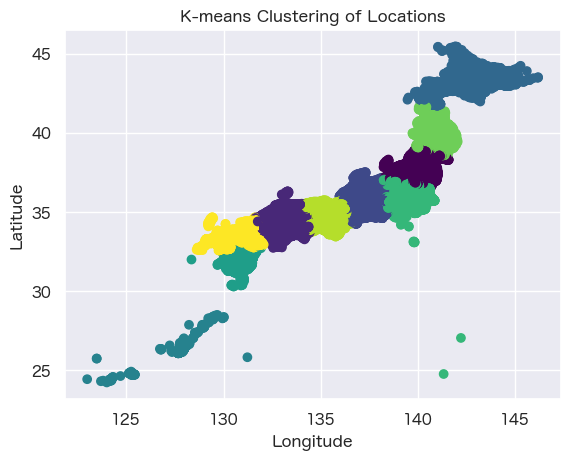

In [23]:
# Convert locations to numpy array
locations_array = stores_pdf[['lat', 'lon']].values

# Normalize the data (optional)
# locations_array_normalized = normalize(locations_array)

# Perform K-means clustering
num_clusters = 10  # Example number of clusters
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(locations_array)

# Get cluster labels
spatial_labels = kmeans.labels_

# Visualize the clustered locations
plt.scatter(locations_array[:, 1], locations_array[:, 0], c=spatial_labels, cmap='viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('K-means Clustering of Locations')
plt.show()



## GMV Analysis: Users vs. Stores
### I. GMV Recency
##### Summary: This analysis focuses on aggregating GMV contributed by users and generated by stores over various time periods. The data reveals that in the past month, approximately 30% of stores accounted for the majority of profits, while a significant portion of users did not contribute to GMV during this period.
##### Features: To enhance our analysis, we will incorporate labeled data indicating the contribution/revenue of individual users and stores as new features.

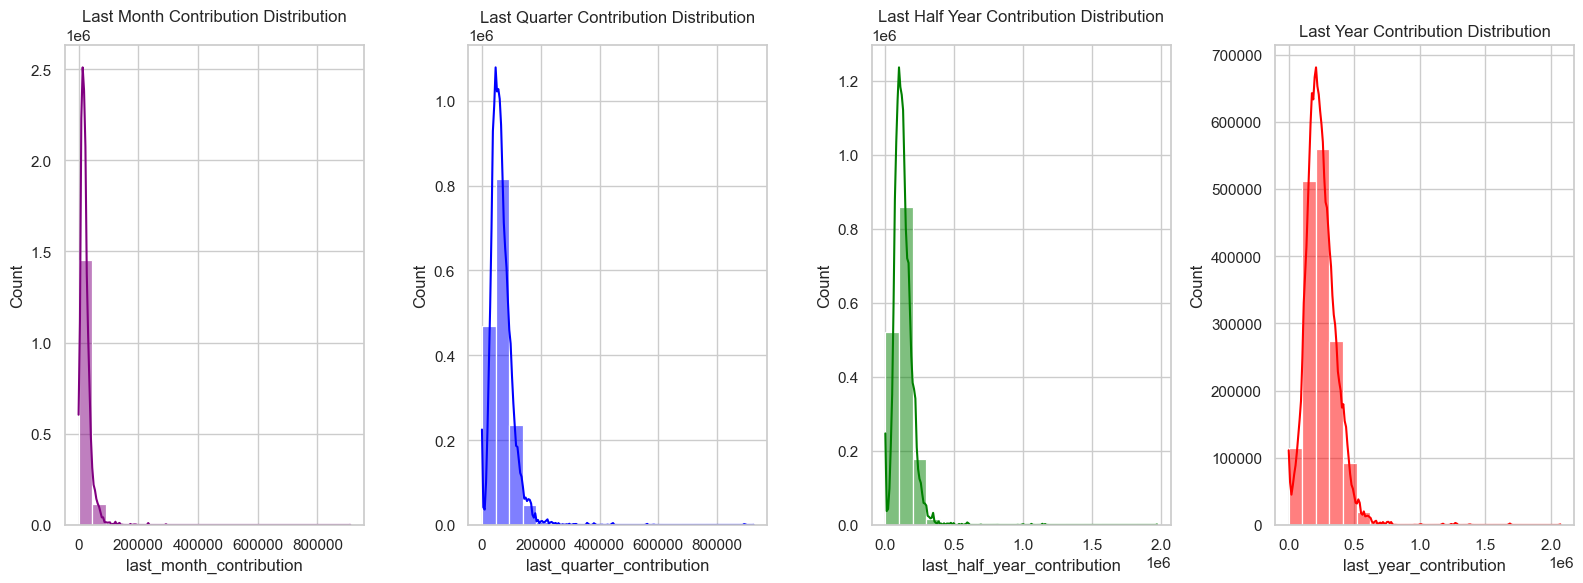

In [24]:
# Convert 'event_occurrence' to datetime
transaction_pdf['event_occurrence'] = pd.to_datetime(transaction_pdf['event_occurrence'])

last_date = transaction_pdf['event_occurrence'].max()

# Calculate the start dates for the last quarter, last half year, and last year
last_month_start = last_date - pd.offsets.DateOffset(months=1)
last_quarter_start = last_date - pd.offsets.DateOffset(months=3)
last_half_year_start = last_date - pd.offsets.DateOffset(months=6)
last_year_start = last_date - pd.offsets.DateOffset(years=1)

# Filter the DataFrame for transactions in the last quarter, last half year, and last year for each user
last_month_transactions = transaction_pdf[transaction_pdf['event_occurrence'] >= last_month_start]
last_quarter_transactions = transaction_pdf[transaction_pdf['event_occurrence'] >= last_quarter_start]
last_half_year_transactions = transaction_pdf[transaction_pdf['event_occurrence'] >= last_half_year_start]
last_year_transactions = transaction_pdf[transaction_pdf['event_occurrence'] >= last_year_start]

# Calculate the sum of 'amount' for each user in the last quarter, last half year, and last year
last_month_contribution = last_month_transactions.groupby('user_id')['amount'].sum()
last_quarter_contribution = last_quarter_transactions.groupby('user_id')['amount'].sum()
last_half_year_contribution = last_half_year_transactions.groupby('user_id')['amount'].sum()
last_year_contribution = last_year_transactions.groupby('user_id')['amount'].sum()

# Merge the results back to the original DataFrame
transaction_pdf['last_month_contribution'] = transaction_pdf['user_id'].map(last_month_contribution).fillna(0)
transaction_pdf['last_quarter_contribution'] = transaction_pdf['user_id'].map(last_quarter_contribution).fillna(0)
transaction_pdf['last_half_year_contribution'] = transaction_pdf['user_id'].map(last_half_year_contribution).fillna(0)
transaction_pdf['last_year_contribution'] = transaction_pdf['user_id'].map(last_year_contribution).fillna(0)

# Plot settings
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

# Plot histograms or KDE plots for each time period
plt.subplot(1, 4, 1)
sns.histplot(transaction_pdf['last_month_contribution'], kde=True, color='purple', bins=20)
plt.title('Last Month Contribution Distribution')

plt.subplot(1, 4, 2)
sns.histplot(transaction_pdf['last_quarter_contribution'], kde=True, color='blue', bins=20)
plt.title('Last Quarter Contribution Distribution')

plt.subplot(1, 4, 3)
sns.histplot(transaction_pdf['last_half_year_contribution'], kde=True, color='green', bins=20)
plt.title('Last Half Year Contribution Distribution')

plt.subplot(1, 4, 4)
sns.histplot(transaction_pdf['last_year_contribution'], kde=True, color='red', bins=20)
plt.title('Last Year Contribution Distribution')

plt.tight_layout()
plt.show()



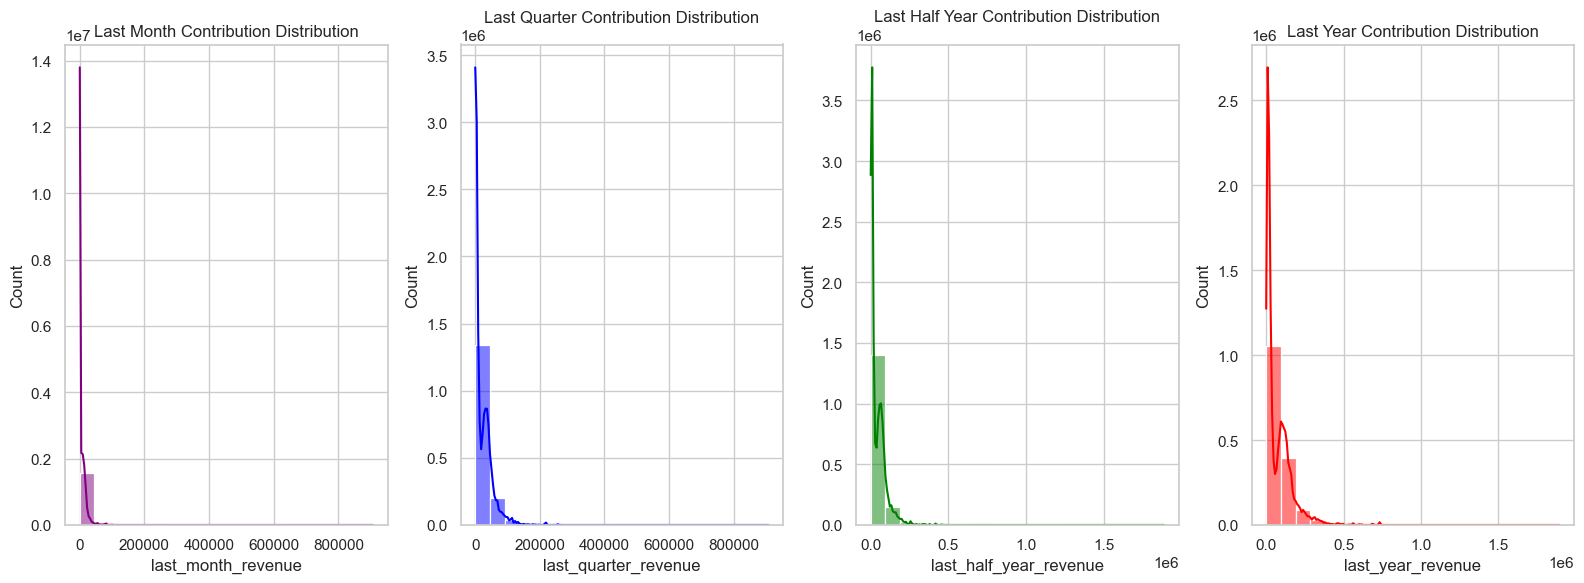

In [25]:
# Calculate the sum of 'amount' for each store in the last month, last quarter, last half year, and last year
last_month_revenue = last_month_transactions.groupby(['store_id'])['amount'].sum()
last_quarter_revenue = last_quarter_transactions.groupby(['store_id'])['amount'].sum()
last_half_year_revenue = last_half_year_transactions.groupby(['store_id'])['amount'].sum()
last_year_revenue = last_year_transactions.groupby(['store_id'])['amount'].sum()

# Merge the results back to the original DataFrame
transaction_pdf['last_month_revenue'] = transaction_pdf['store_id'].map(last_month_revenue).fillna(0)
transaction_pdf['last_quarter_revenue'] = transaction_pdf['store_id'].map(last_quarter_revenue).fillna(0)
transaction_pdf['last_half_year_revenue'] = transaction_pdf['store_id'].map(last_half_year_revenue).fillna(0)
transaction_pdf['last_year_revenue'] = transaction_pdf['store_id'].map(last_year_revenue).fillna(0)


# Plot settings
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

# Plot histograms or KDE plots for each time period
plt.subplot(1, 4, 1)
sns.histplot(transaction_pdf['last_month_revenue'], kde=True, color='purple', bins=20)
plt.title('Last Month Contribution Distribution')

plt.subplot(1, 4, 2)
sns.histplot(transaction_pdf['last_quarter_revenue'], kde=True, color='blue', bins=20)
plt.title('Last Quarter Contribution Distribution')

plt.subplot(1, 4, 3)
sns.histplot(transaction_pdf['last_half_year_revenue'], kde=True, color='green', bins=20)
plt.title('Last Half Year Contribution Distribution')

plt.subplot(1, 4, 4)
sns.histplot(transaction_pdf['last_year_revenue'], kde=True, color='red', bins=20)
plt.title('Last Year Contribution Distribution')

plt.tight_layout()
plt.show()


### II. Order Count Analysis
#### Summary:
This analysis delves into the aggregation of order counts by users and stores across different time periods.

1. User Order Counts:
    - The data indicates an average order count of approximately 15 in the past month.
However, the distribution exhibits a bimodal shape, suggesting potential hidden structures in user purchase behavior.
2. Store Purchases:

    - A notable observation is the presence of stores with no purchase records in the last month.
This indicates that transactions may be occurring predominantly in certain stores, potentially reflecting varying customer preferences or store popularity.

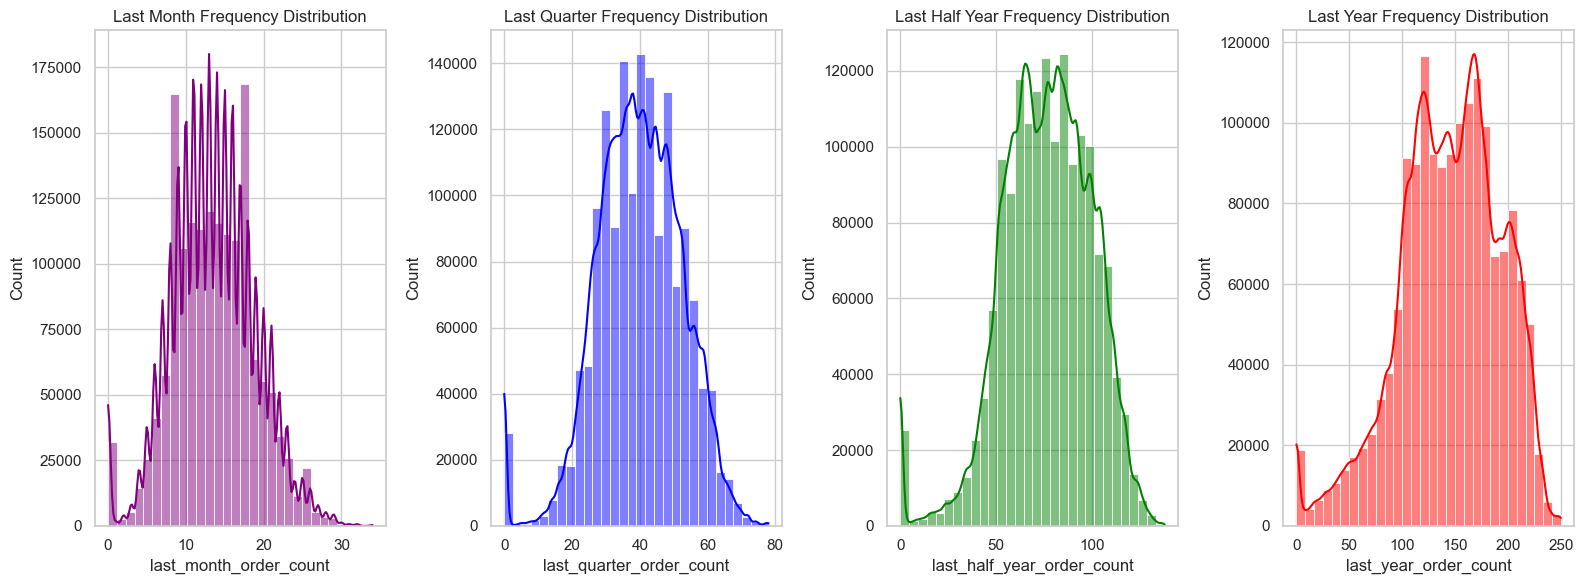

In [95]:
# Convert 'event_occurrence' to datetime
transaction_pdf['event_occurrence'] = pd.to_datetime(transaction_pdf['event_occurrence'])

last_date = transaction_pdf['event_occurrence'].max()

# Calculate the sum of 'amount' for each user in the last quarter, last half year, and last year
last_month_order_count = last_month_transactions.groupby('user_id').size()
last_quarter_order_count = last_quarter_transactions.groupby('user_id').size()
last_half_year_order_count = last_half_year_transactions.groupby('user_id').size()
last_year_order_count = last_year_transactions.groupby('user_id').size()

# Merge the results back to the original DataFrame
transaction_pdf['last_month__count'] = transaction_pdf['user_id'].map(last_month_order_count).fillna(0)
transaction_pdf['last_quarter_order_count'] = transaction_pdf['user_id'].map(last_quarter_order_count).fillna(0)
transaction_pdf['last_half_year_order_count'] = transaction_pdf['user_id'].map(last_half_year_order_count).fillna(0)
transaction_pdf['last_year_order_count'] = transaction_pdf['user_id'].map(last_year_order_count).fillna(0)

# Plot settings
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

# Plot histograms or KDE plots for each time period
plt.subplot(1, 4, 1)
sns.histplot(transaction_pdf['last_month_order_count'], kde=True, color='purple', bins=20)
plt.title('Last Month Frequency Distribution')

plt.subplot(1, 4, 2)
sns.histplot(transaction_pdf['last_quarter_order_count'], kde=True, color='blue', bins=20)
plt.title('Last Quarter Frequency Distribution')

plt.subplot(1, 4, 3)
sns.histplot(transaction_pdf['last_half_year_order_count'], kde=True, color='green', bins=20)
plt.title('Last Half Year Frequency Distribution')

plt.subplot(1, 4, 4)
sns.histplot(transaction_pdf['last_year_order_count'], kde=True, color='red', bins=20)
plt.title('Last Year Frequency Distribution')

plt.tight_layout()
plt.show()



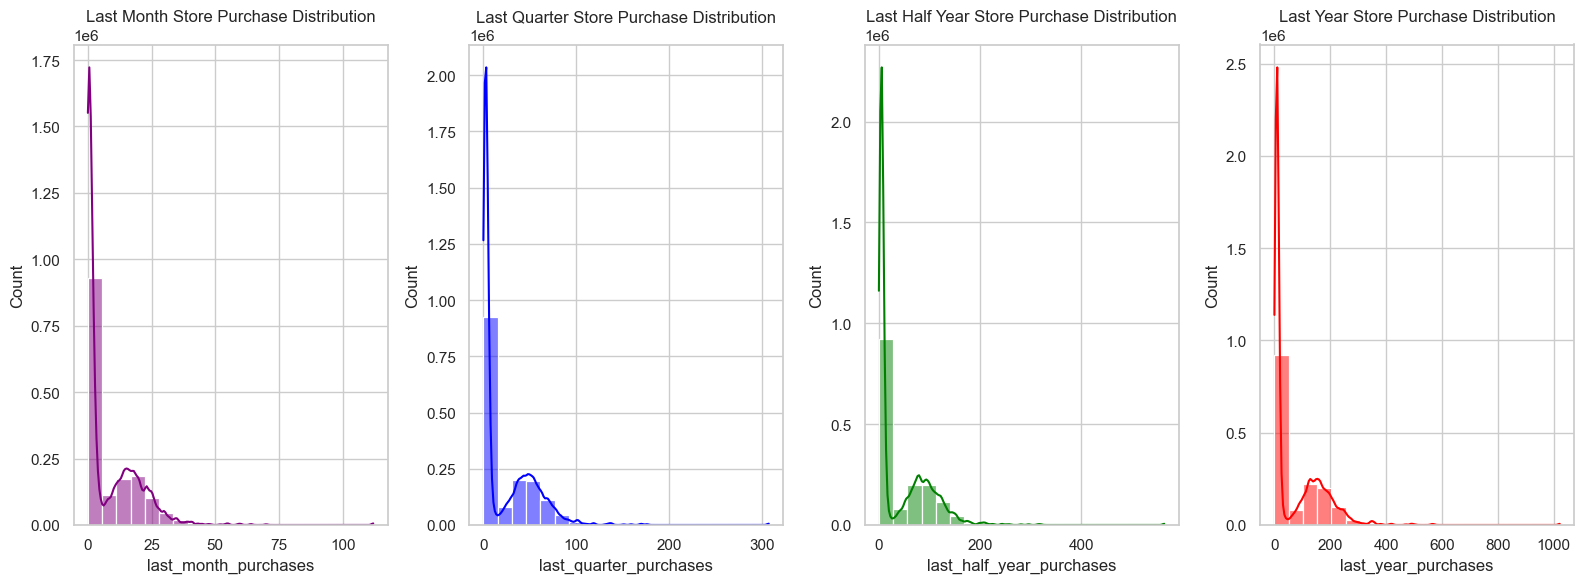

In [96]:
# Convert 'event_occurrence' to datetime
transaction_pdf['event_occurrence'] = pd.to_datetime(transaction_pdf['event_occurrence'])

last_date = transaction_pdf['event_occurrence'].max()

# Calculate the sum of 'amount' for each user in the last quarter, last half year, and last year
last_month_purchases = last_month_transactions.groupby('store_id').size()
last_quarter_purchases = last_quarter_transactions.groupby('store_id').size()
last_half_year_purchases = last_half_year_transactions.groupby('store_id').size()
last_year_purchases = last_year_transactions.groupby('store_id').size()

# Merge the results back to the original DataFrame
transaction_pdf['last_month_purchases'] = transaction_pdf['store_id'].map(last_month_purchases).fillna(0)
transaction_pdf['last_quarter_purchases'] = transaction_pdf['store_id'].map(last_quarter_purchases).fillna(0)
transaction_pdf['last_half_year_purchases'] = transaction_pdf['store_id'].map(last_half_year_purchases).fillna(0)
transaction_pdf['last_year_purchases'] = transaction_pdf['store_id'].map(last_year_purchases).fillna(0)

# Plot settings
plt.figure(figsize=(16, 6))
sns.set(style="whitegrid")

# Plot histograms or KDE plots for each time period
plt.subplot(1, 4, 1)
sns.histplot(transaction_pdf['last_month_purchases'], kde=True, color='purple', bins=20)
plt.title('Last Month Store Purchase Distribution')

plt.subplot(1, 4, 2)
sns.histplot(transaction_pdf['last_quarter_purchases'], kde=True, color='blue', bins=20)
plt.title('Last Quarter Store Purchase Distribution')

plt.subplot(1, 4, 3)
sns.histplot(transaction_pdf['last_half_year_purchases'], kde=True, color='green', bins=20)
plt.title('Last Half Year Store Purchase Distribution')

plt.subplot(1, 4, 4)
sns.histplot(transaction_pdf['last_year_purchases'], kde=True, color='red', bins=20)
plt.title('Last Year Store Purchase Distribution')

plt.tight_layout()
plt.show()



### III. Recency Analysis

#### User Recency:
- The majority of users have made purchases recently, indicating active engagement with the platform. Only a small percentage of users have not made any purchases recently.

#### Store Recency:
- Approximately 60,000 stores have recorded transactions recently, suggesting ongoing business activity. The most frequently visited store has been recorded 11 times, indicating popularity among users.


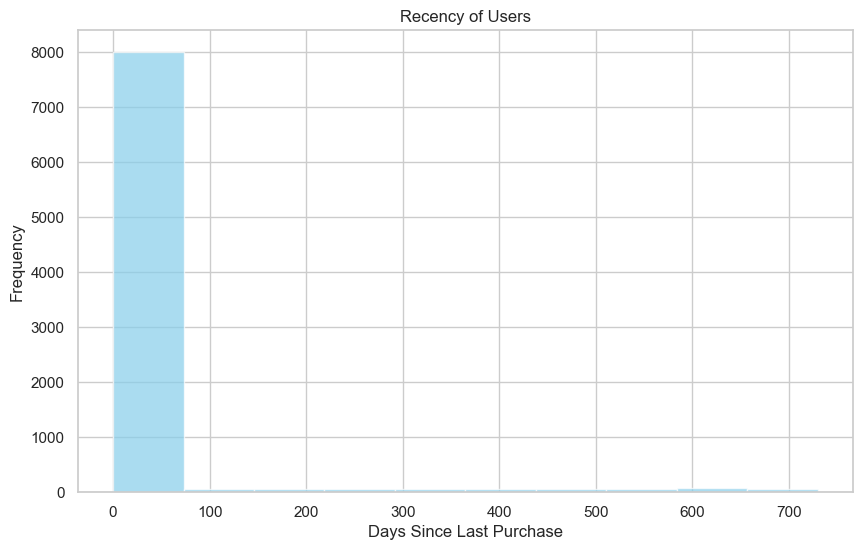

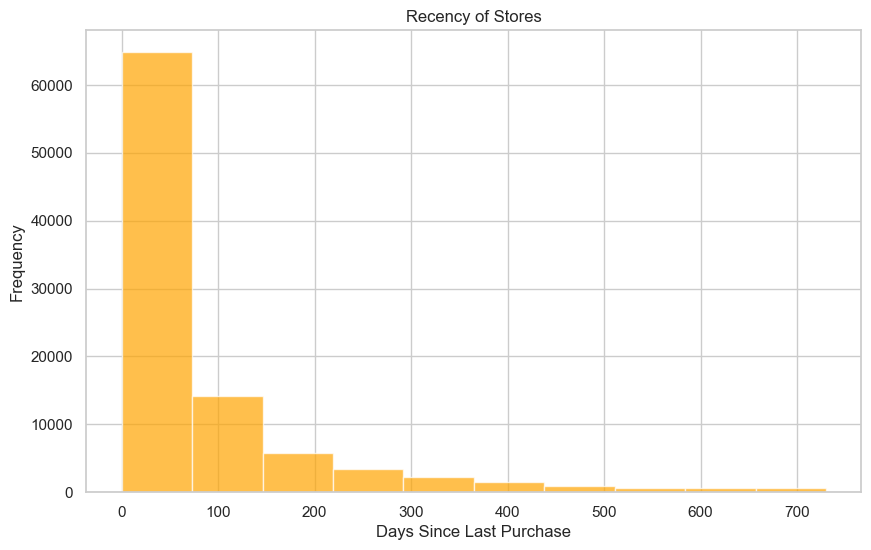

In [109]:
last_transaction_date = full_data_pdf['event_occurrence'].max()

# Calculate recency for users
latest_purchase_user = full_data_pdf.groupby('user_id')['event_occurrence'].max()
recency_user = (last_transaction_date - latest_purchase_user).dt.days

# Calculate recency for stores
latest_purchase_store = full_data_pdf.groupby('store_id')['event_occurrence'].max()
recency_store = (last_transaction_date - latest_purchase_store).dt.days

# Identify the last store visited by users
last_store_visited = full_data_pdf.groupby('user_id')['store_id'].last()


# Plot recency for users
plt.figure(figsize=(10, 6))
plt.hist(recency_user, color='skyblue', alpha=0.7)
plt.title('Recency of Users')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot recency for stores
plt.figure(figsize=(10, 6))
plt.hist(recency_store, color='orange', alpha=0.7)
plt.title('Recency of Stores')
plt.xlabel('Days Since Last Purchase')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()




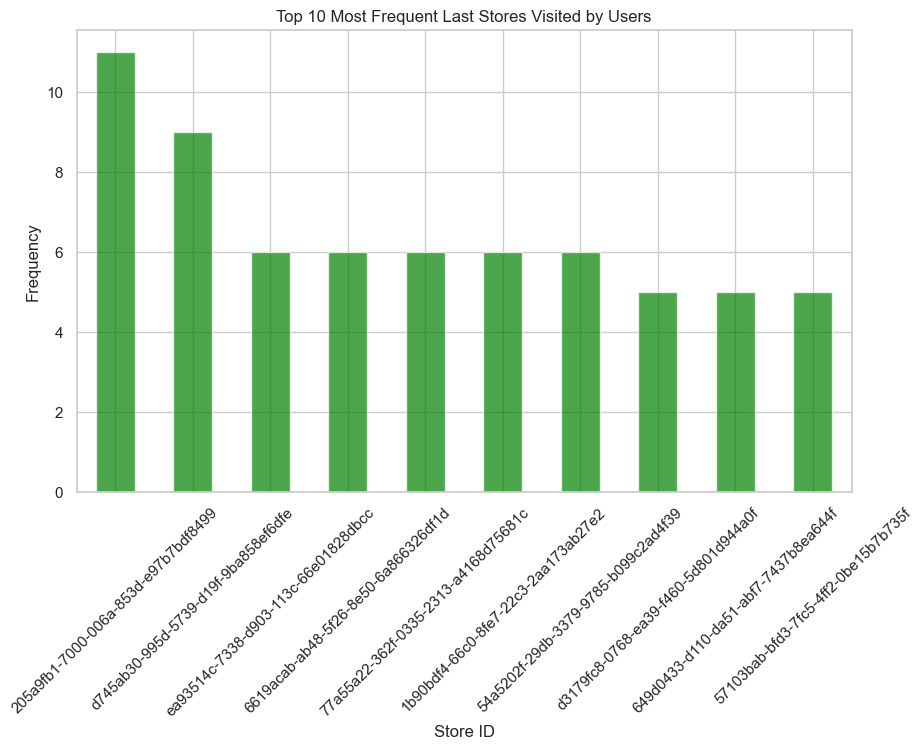

In [114]:
# Get top 10 most frequent stores
top_10_stores = last_store_visited.value_counts().nlargest(10)

# Plot histogram of top 10 stores
plt.figure(figsize=(10, 6))
top_10_stores.plot(kind='bar', color='green', alpha=0.7)
plt.title('Top 10 Most Frequent Last Stores Visited by Users')
plt.xlabel('Store ID')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


### Final Features
- Target_col = "amount"
- Sparse_cols = [
    "age_label", "gender", "nam", "laa", "category", "hour", "weekday", "is_weekend", "month", "season", "spatial_label"
    ]
